This notebook demonstrates how to perform panoptic segmentation on WSIs using a panoptic Cellpose model, trained on high-grade serous carcinoma (HGSC) H&E images (20x resolution). The model weights are available from the [histolytics-hub on Hugging Face](https://huggingface.co/histolytics-hub/cellpose-histo-hgsc-pan-v1).

Panoptic segmentation enables simultaneous segmentation and classification of both nuclei and tissue regions within WSIs, enabling spatially aware downstream analyses. 

For more details of the available pre-trained models, visit the [histolytics-hub on Hugging Face](https://huggingface.co/histolytics-hub).

In this notebook, we will:
- Load a pre-trained panoptic Cellpose model.
- Prepare and process WSIs for segmentation.
- Run large-scale inference and save the results to .parquet files
- Visualize results.

In [ ]:
# !pip install albumentations
# !pip install cucim-cu12

In [3]:
from platform import python_version

import torch
import albumentations as A
import cellseg_models_pytorch

print("torch version:", torch.__version__)
print("albumentations version:", A.__version__)
print("cellseg_models_pytorch version:", cellseg_models_pytorch.__version__)
print("python version:", python_version())

torch version: 2.7.0+cu126
albumentations version: 2.0.6
cellseg_models_pytorch version: 0.1.26
python version: 3.12.3


## Easy Initialization and Model Weights Loading

In Histolytics, the panoptic segmentation models can be initialized with pre-trained weights using the `from_pretrained`-method. By specifying the desired weights (e.g., `"hgsc_v1_efficientnet_b5"`), the model automatically downloads and loads the appropriate weights from the model hub.

In [4]:
from histolytics.models.cellpose_panoptic import CellposePanoptic

model = CellposePanoptic.from_pretrained(weights="hgsc_v1_efficientnet_b5")
model.set_inference_mode(mixed_precision=False)

## SlideReader: Reading Whole Slide Images

The `SlideReader` object handles reading WSIs. The reader backends include:

- **CUCIM**: NVIDIA's accelerated backend for efficient WSI reading.
- **OPENSLIDE**: A widely-used open-source backend compatible with many WSI formats.
- **BIOIO**: A flexible backend supporting a broad range of bioimaging formats.

After loading a slide, `SlideReader` can generate a tissue mask using Otsu-based thresholding, which automatically distinguishes tissue regions from the background. For further refining, the `get_sub_grids` function can be used to filter tile coordinates based on connected components in the tissue mask. This ensures that only contiguous tissue regions are selected for downstream processing, improving both efficiency and accuracy in large-scale WSI analysis.

In [ ]:
from histolytics.wsi.slide_reader import SlideReader
from histolytics.wsi.utils import get_sub_grids
from pathlib import Path

sl_path = Path().home() / "sample.tiff"  # Replace with your WSI path

# Initialize SlideReader with CUCIM backend
reader = SlideReader(sl_path, backend="CUCIM")

# Get the tissue mask and coordinates
thresh, tissue_mask = reader.get_tissue_mask(level=-2)
coordinates = reader.get_tile_coordinates(width=1024, tissue_mask=tissue_mask)

# Get the contiguous sub-grids
sub_grids = get_sub_grids(coordinates)
filtered_sub_grids = [grid for grid in sub_grids if len(grid) > 100]

# pick the first sub-grid
sub_coords = filtered_sub_grids[0]

# visualize the thumbnail and the sub-coordinates
# thumbnail = reader.read_level(-2)
# reader.get_annotated_thumbnail(thumbnail, sub_coords, linewidth=1)

In [ ]:
len(sub_coords)  # 2620 1024x1024 tiles

2620

## WsiPanopticSegmenter: Running Panoptic Segmentation on WSIs

The `WsiPanopticSegmenter` class orchestrates the process of running panoptic segmentation on WSIs. It manages the model inference, and post-processing, making it easy to apply a panoptic segmentation model to large WSIs. It takes in a `SlideReader` object and a pre-trained panoptic segmentation model, and provides methods to run inference on the entire slide.

In [ ]:
import albumentations as A
from histolytics.transforms import MinMaxNormalization
from histolytics.wsi.wsi_segmenter import WsiPanopticSegmenter

# We will use the MinMaxNormalization transform to normalize the input images
# This was also used in the training of the model
img_transforms = A.Compose([MinMaxNormalization()])

wsi_segmenter = WsiPanopticSegmenter(
    reader=reader,
    model=model,
    level=0,  # 20x magnification
    coordinates=sub_coords,
    batch_size=8,
    transforms=img_transforms,
)

## Run segmentation on a WSI

**Note:** Running panoptic segmentation on a whole slide image (WSI) can take a some amount of time, depending on the size of the slide and available hardware resources. 

In [10]:
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

save_dir = Path().home() / "seg_res"

wsi_segmenter.segment(
    save_dir=save_dir,
    use_sliding_win=False,
    use_async_postproc=True,
    postproc_njobs=4,
    postproc_start_method="threading",
    class_dict_nuc=model.nuc_classes,
    class_dict_tissue=model.tissue_classes,
)

  0%|          | 0/328 [00:00<?, ?batch/s]

100%|██████████| 328/328 [47:59<00:00,  8.78s/batch] 


## Merging Nuclear and Tissue Segmentation Instances

After running `.segment`, the WSI is processed tile-by-tile, resulting in segmented nuclear and tissue instances for each tile. To reconstruct the full WSI segmentation, these tile-level results must be merged into a single, coherent set of instances for both nuclei and tissue.

The `WsiPanopticSegmenter` provides dedicated methods for this purpose:
- `merge_instances`: Merges nuclear segmentation results from all tiles into a single file.
- `merge_tissues`: Merges tissue segmentation results from all tiles into a single file.

These methods handle spatial alignment, instance ID management, and optional geometry simplification, ensuring that the final merged outputs are ready for downstream analysis and visualization. Each output is saved as a `.parquet` file for efficient storage and access.

In [12]:
wsi_segmenter.merge_instances(
    src=save_dir / "nuc", dst=save_dir / "out.parquet", simplify_level=0.1
)

Merging objects (y-axis): 100%|██████████| 71/71 [03:10<00:00,  2.68s/it]


**NOTE:** When visualizing the segmentation results with GeoPandas, the plots may appear upside down. This is because GeoPandas uses the origin at the bottom-left corner, whereas image data typically uses the top-left as the origin. The actual coordinates in the data are not flipped and this effect is only present in the visualization.

<Axes: >

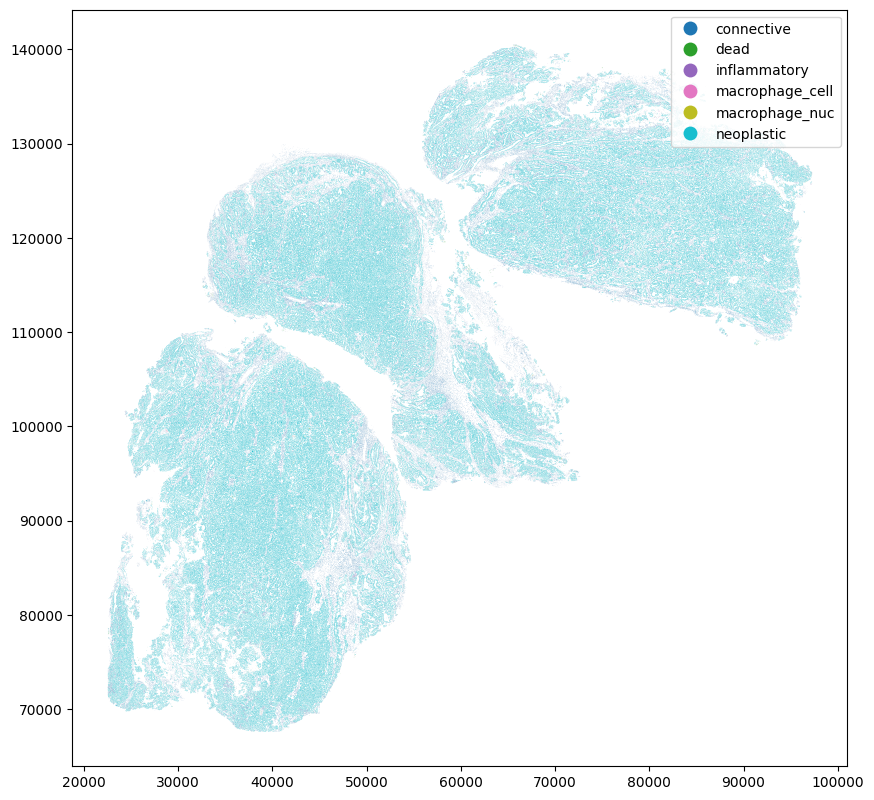

In [14]:
import geopandas as gpd

cells = gpd.read_parquet(save_dir / "out.parquet")
cells.plot(column="class_name", figsize=(10, 10), legend=True)

In [ ]:
wsi_segmenter.merge_tissues(
    src=save_dir / "tissue", dst=save_dir / "out_tissue.parquet", simplify_level=0.5
)

Merging tissues by class: 100%|██████████| 6/6 [03:06<00:00, 31.06s/it]


<Axes: >

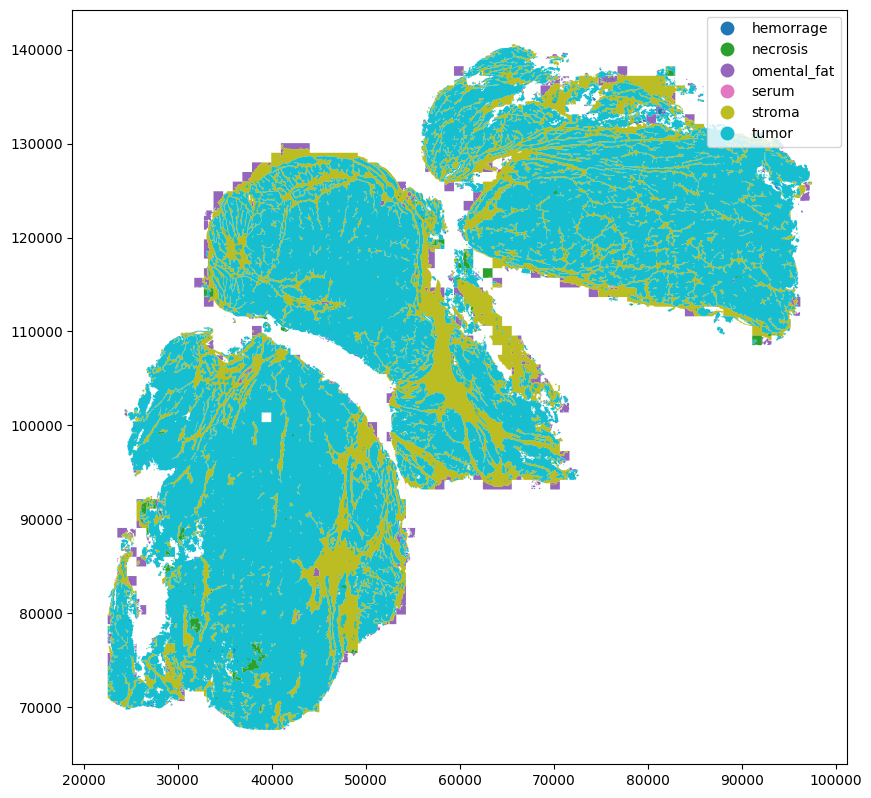

In [16]:
tissues = gpd.read_parquet(save_dir / "out_tissue.parquet")
tissues.plot(column="class_name", figsize=(10, 10), legend=True)